In [1]:
import qiskit
from qiskit.quantum_info import state_fidelity
import numpy as np
from scipy.sparse import linalg as LA
import qib
import matplotlib.pyplot as plt
import rqcopt as oc
import scipy
import scipy.sparse as sp


L = 10
J = ( 1, 1, 1)
h = ( 1, 1, 1)

# construct Hamiltonian
latt = qib.lattice.IntegerLattice((L, ), pbc=True)
field = qib.field.Field(qib.field.ParticleType.QUBIT, latt)

hamil = qib.HeisenbergHamiltonian(field, J, h).as_matrix()
eigenvalues, eigenvectors = LA.eigsh(hamil, k=100)
idx = eigenvalues.argsort()
eigenvalues_sort = eigenvalues[idx]
eigenvectors_sort = eigenvectors[:,idx]
ground_state = eigenvectors_sort[:, 0]

print("Ground State Energy", eigenvalues_sort[0].real)
print("Average Energy: ", eigenvalues_sort[0]/L)
E_exact = eigenvalues_sort[0]/L

Ground State Energy -19.83293100209279
Average Energy:  -1.9832931002092788


In [2]:
"""
    Compressed-Controlled Time Evolution Operator that we optimized previously.
"""
import h5py
import sys
sys.path.append("../../src/brickwall_ansatz")
from utils import construct_heisenberg_local_term, construct_ising_local_term, get_params, reduce_list
from ansatz import ansatz, construct_ccU


# Best Performing Setting I observed so far was (2, 5).
L = 4
t = 0.25
eta, gamma = (2, 5)
nlayers = eta*gamma+gamma+1
perms = [[i for i in range(L)] if i%2==0 else [i for i in range(1, L)]+[0] for i in range(nlayers)]
Vs = []
with h5py.File(f"./results/heisenberg1d_111_L{L}_t{t}_layers{nlayers}_gamma{gamma}_eta{eta}.hdf5", "r") as f:
    Vs = f["Vlist"][:]

L = 10
latt = qib.lattice.IntegerLattice((L,), pbc=True)
field = qib.field.Field(qib.field.ParticleType.QUBIT, latt)
hamil = qib.HeisenbergHamiltonian(field, J, h).as_matrix().toarray()
perms = [[i for i in range(L)] if i%2==0 else [i for i in range(1, L)]+[0] for i in range(nlayers)]

U = scipy.linalg.expm(-1j*hamil*t)
U_back = scipy.linalg.expm(1j*hamil*t)

print("Trotter error for same time, larger system: ", (np.linalg.norm(ansatz(reduce_list(Vs, gamma, eta), L, 
            reduce_list(perms, gamma, eta)) - U, ord=2)+np.linalg.norm(
        ansatz(Vs, L, perms) - U_back, ord=2))/2)

#  Controlled Two qubit Gates Decomposed & Optimized Previously.
Xlists_opt = {}
perms_qc = [[0, 1], [0, 2], [1, 2], [0, 2], [0, 1], [1, 2], [0, 2], [0, 1], [1, 2]]
for i in range(0, nlayers, eta+1):
    with h5py.File(f"./results/heisenberg1d_111_L4_t{t}_layers{nlayers}_gamma{gamma}_eta{eta}_CUs_APPROXS_n{len(perms_qc)}_layer{i}.hdf5", "r") as file:
        Xlists_opt[i] = file[f"Xlist_{i}"][:]

qc_cU = construct_ccU(L, eta, Vs, Xlists_opt, perms, perms_qc)


Trotter error for same time, larger system:  0.05030806768166928


In [10]:
"""
    Trotter error of the optimal gates construct.
"""

from qiskit import Aer, execute, transpile
from qiskit.converters import circuit_to_dag
from qiskit.providers.aer.noise import NoiseModel, errors

I2 = np.eye(2)
X = np.array([[0, 1], [1, 0]])
Y = np.array([[0, -1j], [1j, 0]])
Z = np.array([[1, 0], [0, -1]])
ket_0 = np.array([[1],[0]])
ket_1 = np.array([[0],[1]])
rho_0_anc = ket_0 @ ket_0.T
rho_1_anc = ket_1 @ ket_1.T

U = scipy.linalg.expm(-1j * t * hamil)
cU = np.kron(rho_0_anc, U.conj().T) + np.kron(rho_1_anc, U)
backend = Aer.get_backend("unitary_simulator")
qc_unit = execute(transpile(qc_cU), backend).result().get_unitary(qc_cU, L+1).data
noise_model = NoiseModel()
dag = circuit_to_dag(transpile(qc_cU, basis_gates=noise_model.basis_gates+['unitary', 'initialize', 'cx']))
count_ops = dag.count_ops()

print(f"t={t}, Gate Count: ", count_ops['unitary'], " Trotter error: ", np.linalg.norm(qc_unit - cU, ord=2))

/tmp/ipykernel_35308/4053000614.py:21: DeprecationWarning: The function ``qiskit.execute_function.execute()`` is deprecated as of qiskit 0.46.0. It will be removed in the Qiskit 1.0 release. This function combines ``transpile`` and ``backend.run``, which is covered by ``Sampler`` :mod:`~qiskit.primitives`. Alternatively, you can also run :func:`.transpile` followed by ``backend.run()``.
  qc_unit = execute(transpile(qc_cU), backend).result().get_unitary(qc_cU, L+1).data


t=0.25, Gate Count:  320  Trotter error:  0.07297661192752307


In [53]:
"""

    Exact Initialization + Iterative QPE
    Let's assume we can efficiently encode a DMRG ground state.

"""
import sys
sys.path.append("../../src/qpe")
from qpe import estimate_phases

def norm_mod2pi(theta):
    return np.pi - np.abs((theta%(2*np.pi)) - np.pi) 

def run_QPE(qc_prepared_state, qc_cU, basis_time, init_guess, Ns, final_digit, depolarizing_error):
    theta_prev = -init_guess
    est_prev = init_guess

    x1_error = errors.depolarizing_error(depolarizing_error*0.01, 1)
    x2_error = errors.depolarizing_error(depolarizing_error, 2)
    noise_model = NoiseModel()
    noise_model.add_all_qubit_quantum_error(x1_error, ['u1', 'u2', 'u3'])
    noise_model.add_all_qubit_quantum_error(x2_error, ['cu3', 'cx', 'str', 'cy', 'cz', 'unitary'])
    
    Es = []
    ests_ = []
    thetas_ = []
    cxss_A = []
    mid_cbits = 0
    mid_errs_A = []
    for j in list(range(-1, final_digit+1, 1)):
        T = 2**j
        theta_prev_ = theta_prev
        counts_real, counts_imag, cxs, qasm = estimate_phases(
                                                L, qc_C, eigenvalues_sort, T/2, basis_time,
                                                Ns, depolarizing_error, qc_cU, noise_model=noise_model,
                                                return_counts=True,
                                                get_cx=True, qasm=True
                                           )[0]
        cxss_A.append(cxs['unitary'])
        print('CXs: ', cxss_A[-1])
    
        phase_est_real = ((counts_real['0'] if '0' in counts_real else 0) - (counts_real['1'] if '1' in counts_real else 0)) /\
                    ((counts_real['0'] if '0' in counts_real else 0) + (counts_real['1'] if '1' in counts_real else 0))     
        phase_est_imag = ((counts_imag['0'] if '0' in counts_imag else 0) - (counts_imag['1'] if '1' in counts_imag else 0)) /\
                    ((counts_imag['0'] if '0' in counts_imag else 0) + (counts_imag['1'] if '1' in counts_imag else 0))
        phase = phase_est_real + 1j*phase_est_imag
                
        print("Exact Phase: ", np.exp(-1j * T * eigenvalues_sort[0]))
        print("Estimated Phase: ", phase)
                
        if phase.real != 0:
            angle = np.arctan(phase.imag/phase.real) if phase.real>0 else (np.pi + np.arctan(phase.imag/phase.real) if phase.imag>0 else \
                                                                               np.arctan(phase.imag/phase.real) - np.pi)
        else:
            angle = np.pi/2 if phase.imag > 0 else -np.pi/2

    
        if T>1:
            thetas = [(angle + k*2*np.pi)/T for k in range(T+1)]
            norms = np.array([norm_mod2pi(theta - theta_prev) for theta in thetas])
            id_ = np.argmin(norms)
                    
            ests = [-thetas[id_] - coe*np.pi for coe in range(2, 40, 2)]
            est = ests[0]
            for est_ in ests[1:]:
                est = est_ if np.abs(est_-est_prev) < np.abs(est-est_prev) else est
            ests_.append(est)
            thetas_.append(thetas[id_])
            theta_prev = thetas_[-1]
        else:
            thetas = [(angle + k*np.pi)/T for k in range(0, 40, 2)]
            ests = [-theta for theta in thetas]
            est = ests[0]
            for est_ in ests[1:]:
                est = est_ if np.abs(est_-est_prev) < np.abs(est-est_prev) else est
            ests_.append(est)
            thetas_.append(-est)
            theta_prev = thetas_[-1]
    
        est_prev = ests_[-1]
        print("Final Estimation Result, Abs Error: ", np.abs(est_prev-eigenvalues_sort[0]))    
        print("Final Estimation Result, Relative Error: ", np.abs(est_prev-eigenvalues_sort[0])/np.abs(eigenvalues_sort[0]), '\n')    
        mid_errs_A.append(np.abs(est_prev-eigenvalues_sort[0]))
        Es.append(est_prev)
    return Es

In [75]:
from qiskit.quantum_info import Statevector

s = (ground_state * 0.7 + eigenvectors_sort[:, 1] * 0.3)
s = s/np.linalg.norm(s)
state = Statevector(np.kron(np.array([1, 0]), s))
qc_C = qiskit.QuantumCircuit(L+1, 1)
qc_C.initialize(state, [i for i in range(L+1)])

Es_ccU = run_QPE(qc_C, qc_cU, t, -25, 3000, 2, 1e-3)

t:  0.25
nsteps:  1
getting counts
CXs:  320
Exact Phase:  (-0.8815374024953675-0.47211418957887763j)
Estimated Phase:  (-0.6786666666666666-0.2853333333333333j)
Final Estimation Result, Abs Error:  0.18738439276055985
Final Estimation Result, Relative Error:  0.009448144237520257 

t:  0.5
nsteps:  2
getting counts
CXs:  640
Exact Phase:  (0.5542163839965591+0.8323726327251386j)
Estimated Phase:  (0.3433333333333333+0.38066666666666665j)
Final Estimation Result, Abs Error:  0.14645717075630316
Final Estimation Result, Relative Error:  0.007384544964173418 

t:  1.0
nsteps:  4
getting counts
CXs:  1280
Exact Phase:  (-0.3856883994195569+0.9226291012932447j)
Estimated Phase:  (-0.042666666666666665+0.238j)
Final Estimation Result, Abs Error:  0.10928321038340627
Final Estimation Result, Relative Error:  0.00551018961200816 

t:  2.0
nsteps:  8
getting counts
CXs:  2560
Exact Phase:  (-0.7024889171063606-0.7116946826713916j)
Estimated Phase:  (-0.07266666666666667-0.018j)
Final Estimatio

In [76]:
from qiskit import Aer, execute, transpile
from qiskit.circuit.library import CYGate, CZGate, IGate, CXGate
from qiskit.converters import circuit_to_dag
from qiskit.providers.aer.noise import NoiseModel, errors
from qiskit.quantum_info import Statevector

hloc1 = construct_heisenberg_local_term((J[0], 0   ,    0), (0, h[1], 0))
hloc2 = construct_heisenberg_local_term((0   , J[1],    0), (0, 0, h[2]))
hloc3 = construct_heisenberg_local_term((0   , 0   , J[2]), (h[0], 0, 0))
hlocs = ((hloc1, ), (hloc2, ), (hloc3, ))
cgates = ((CXGate, CZGate), (CXGate, CYGate), (CZGate, CYGate))
qc_cU_trotter = cU_trotter(t, L, hlocs, cgates, trotter_step=0.1, trotter_degree=3)
Es_trotter = run_QPE(qc_C, qc_cU_trotter, t, -25, 3000, 2, 1e-3)

t:  0.25
nsteps:  1
getting counts
CXs:  270
Exact Phase:  (-0.8815374024953675-0.47211418957887763j)
Estimated Phase:  (-0.418-0.18733333333333332j)
Final Estimation Result, Abs Error:  0.14071985051119285
Final Estimation Result, Relative Error:  0.0070952624448874435 

t:  0.5
nsteps:  2
getting counts
CXs:  540
Exact Phase:  (0.5542163839965591+0.8323726327251386j)
Estimated Phase:  (0.14066666666666666+0.12333333333333334j)
Final Estimation Result, Abs Error:  0.26353938231069307
Final Estimation Result, Relative Error:  0.013287969502988951 

t:  1.0
nsteps:  4
getting counts
CXs:  1080
Exact Phase:  (-0.3856883994195569+0.9226291012932447j)
Estimated Phase:  (-0.009333333333333334+0.03933333333333333j)
Final Estimation Result, Abs Error:  0.08148729761802898
Final Estimation Result, Relative Error:  0.004108686588453838 

t:  2.0
nsteps:  8
getting counts
CXs:  2160
Exact Phase:  (-0.7024889171063606-0.7116946826713916j)
Estimated Phase:  (0.021333333333333333-0.0093333333333333

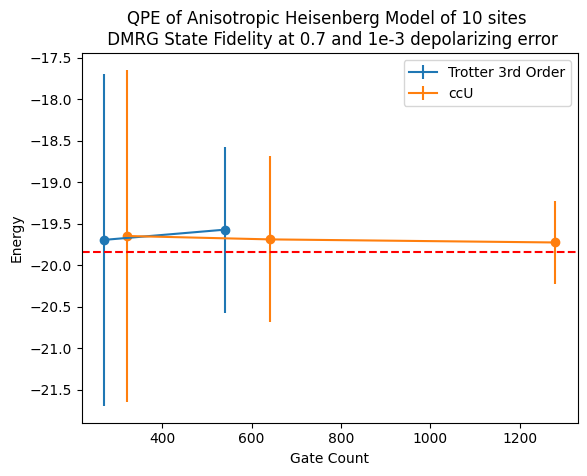

In [79]:
plt.errorbar([270, 540], Es_trotter[:2], yerr=[(2, 1), (2, 1)], label='Trotter 3rd Order')
plt.scatter([270, 540], Es_trotter[:2])

plt.errorbar([320, 640, 1280], Es_ccU[:3], yerr=[(2, 1, .5), (2, 1, .5)], label='ccU')
plt.scatter([320, 640, 1280], Es_ccU[:3])

plt.ylabel("Energy")
plt.xlabel("Gate Count")

plt.axhline(eigenvalues_sort[0], ls='--', color='red')

plt.title("QPE of Anisotropic Heisenberg Model of 10 sites \n DMRG State Fidelity at 0.7 and 1e-3 depolarizing error")
plt.savefig("./figs/heisenberg1d_111_qpe.png", dpi=300)
plt.legend()

In [20]:
"""
    Now here is to compare the performance of the ccU circuit
    with the 1st and 2nd order Trotter circuits, in terms of 
    gate count vs Trotter error. I demonstrate it on L=8 system.
"""

from qiskit import Aer, execute, transpile
from qiskit.circuit.library import CYGate, CZGate, IGate, CXGate
from qiskit.converters import circuit_to_dag
from qiskit.providers.aer.noise import NoiseModel, errors


def uncompr_trotterized_time_evolution(qc, hlocs, t, gate, lamb=None):
    # permutations specifying gate layout
    perms1 = [i for i in range(L)]
    perms2 = [i for i in range(1, L)]+[0]
    perm_set = [perms1, perms2]
    perms = perm_set
    
    K_layer = [None for _ in range(L)]
    for j in range(len(perms[0])//2):
        K_layer[perms[0][2*j]] = gate[0]
        K_layer[perms[0][2*j+1]] = gate[1]
        
    K_b = [K_layer, None]
    K_a = [None, K_layer]
    
    Vlists = [[scipy.linalg.expm(-1j*t*hloc) for i in range(len(perm_set))] for hloc in hlocs]
    Vlists_gates = [[] for _ in hlocs]
    for i, Vlist in enumerate(Vlists):
        for V in Vlist:
            qc2 = qiskit.QuantumCircuit(2)
            qc2.unitary(V, [0, 1], label='str')
            Vlists_gates[i].append(qc2)


    for layer in range(len(perms)):
        if K_b[layer] is not None:
            qc.x(L)
            for j in range(L):
                if K_b[layer][j] is not None:
                    qc.append(K_b[layer][j](), [L, L-1-j])
            qc.x(L)

            
        for Vlist_gates in Vlists_gates:
            qc_gate = Vlist_gates[layer]
            
            for j in range(len(perms[layer])//2):
                    qc.append(qc_gate.to_gate(), [L-(perms[layer][2*j]+1), 
                                                    L-(perms[layer][2*j+1]+1)])

        if K_a[layer] is not None:
            qc.x(L)
            for j in range(L):
                if K_a[layer][j] is not None:
                    qc.append(K_a[layer][j](), [L, L-1-j])
            qc.x(L)


def cU_trotter(t, L, hlocs, cgates, dagger=False, nsteps=1, trotter_degree=2, trotter_step=0.1):
    if t/(nsteps) > trotter_step:
        nsteps = int(np.ceil(t/trotter_step))
    dt = t/(nsteps)
    qc_cU_ins = qiskit.QuantumCircuit(L+1)
    
    # Trotter 2nd Order.
    indices = [0, 1, 2, 1, 0]
    coeffs  = [0.5, 0.5, 1, 0.5, 0.5]
    if trotter_degree==1:
        # Trotter 1st Order.
        indices = [0, 1, 2]
        coeffs  = [1, 1, 1]
    if trotter_degree==3:
        # Trotter 3rd Order.
        indices = [0, 1, 2, 1, 0, 1, 2, 1, 0]
        coeffs  = [0.25, 0.25, 0.5, 0.25, 0.5, 0.25, 0.5, 0.25, 0.25]
        
    for n in range(nsteps):
        for index, coef in zip(indices, coeffs):
            uncompr_trotterized_time_evolution(qc_cU_ins, hlocs[index], dt * coef, cgates[index])

    return qc_cU_ins
    